# Athlete Performance Prediction

An AI-driven system designed to predict athlete performance and assess the risk of injury. This system leverages historical performance data, physiological metrics, and contextual factors to provide actionable insights. 

Key features of the system include:
- **Performance Prediction**: Forecasts athlete performance based on training schedules, fatigue levels, and other metrics.
- **Injury Risk Assessment**: Identifies athletes at risk of injury by analyzing physiological and contextual data.
- **Search Techniques**: Implements advanced search algorithms such as Greedy Search, A* Search, and Uninformed Search to optimize training plans.
- **Constraint Satisfaction Problems (CSP)**: Ensures training plans adhere to constraints like fatigue thresholds and risk limits.
- **Optimization Algorithms**: Utilizes techniques like Genetic Algorithms to explore and identify optimal training schedules.

This system aims to enhance decision-making in athlete training and performance management by combining predictive analytics with optimization strategies.

## 0. Data Collection & Preprocessing

In [ ]:
# import os
# import zipfile
# import json
# import pandas as pd

# # ─── CONFIG ───────────────────────────────────────────────────────────────
# RawData     = "data/subjective.zip"
# cleanedData   = "data/soccer_data_cleaned.csv"
# os.makedirs(os.path.dirname(cleanedData) or ".", exist_ok=True)

# with zipfile.ZipFile(RawData, "r") as z:
#     # 1a) daily load
#     with z.open("subjective/training-load/daily_load.csv") as f:
#         df_load = pd.read_csv(f)
#     df_load = (
#         df_load.rename(columns={"Date": "date"})
#                .assign(date=lambda d: pd.to_datetime(d["date"], dayfirst=True))
#                .melt(id_vars="date", var_name="player_id", value_name="load")
#     )

#     # 1b) session-RPE JSON
#     with z.open("subjective/training-load/session.json") as f:
#         sess = json.load(f)
#     rows = []
#     for pid, sess_list in sess.items():
#         for s in sess_list:
#             rows.append({
#                 "player_id":     pid,
#                 "date":          pd.to_datetime(s["date"], dayfirst=True),
#                 "total_duration": s["duration"]
#             })
#     df_sess = (pd.DataFrame(rows)
#                  .groupby(["player_id", "date"], as_index=False)
#                  .agg(total_duration=("total_duration", "sum")))

#     # 1c) game-performance
#     with z.open("subjective/game-performance/game-performance.csv") as f:
#         df_game = pd.read_csv(f)
#     df_game = (
#         df_game.assign(
#             date=pd.to_datetime(df_game["timestamp"], format="%d.%m.%Y")
#         )
#         .rename(columns={"player_name": "player_id"})
#     )
#     df_game["performance_metric"] = (
#         df_game["offensive_performance"] + df_game["defensive_performance"]
#     ) / 2

#     # 1d) injury
#     with z.open("subjective/injury/injury.csv") as f:
#         df_inj = pd.read_csv(f)
#     df_inj = (
#         df_inj.assign(
#             date=pd.to_datetime(df_inj["timestamp"], format="%d.%m.%Y"),
#             injury_flag=1
#         )
#         .rename(columns={"player_name": "player_id"})
#         [["player_id", "date", "injury_flag"]]
#         .drop_duplicates()
#     )

#     # 1e) wellness
#     def load_well(path, col):
#         with zipfile.ZipFile(RawData) as zz:
#             with zz.open(path) as ff:
#                 w = pd.read_csv(ff)
#         return (
#             w.rename(columns={w.columns[0]: "date"})
#              .assign(date=lambda d: pd.to_datetime(d["date"], dayfirst=True))
#              .melt(id_vars="date", var_name="player_id", value_name=col)
#         )

#     wellness_map = {
#         "subjective/wellness/fatigue.csv":        "fatigue_post",
#         "subjective/wellness/sleep_duration.csv": "sleep_duration",
#         "subjective/wellness/sleep_quality.csv":  "sleep_quality",
#         "subjective/wellness/stress.csv":         "stress",
#     }

# # ─── 2) MERGE ALL ───────────────────────────────────────────────────────────
# # start with load
# df = df_load

# # merge game perf & raw metrics
# df = df.merge(
#     df_game[["player_id","date","performance_metric","offensive_performance","defensive_performance"]],
#     on=["player_id","date"], how="left"
# )

# # merge injury
# df = df.merge(df_inj, on=["player_id","date"], how="left")
# df["injury_flag"] = df["injury_flag"].fillna(0).astype(int)

# # merge wellness
# for path, col in wellness_map.items():
#     df = df.merge(load_well(path, col), on=["player_id","date"], how="left")

# # merge session durations
# df = df.merge(df_sess, on=["player_id","date"], how="left")
# df["total_duration"] = df["total_duration"].fillna(0)

# # ─── 2b) FILL SPECIFIC MISSING WELLNESS VALUES ─────────────────────────────
# fill_with_median = ["sleep_duration", "sleep_quality", "stress"]
# for col in fill_with_median:
#     if col in df.columns:
#         median_val = df[col].median()
#         df[col] = df[col].fillna(median_val)

# # ─── 3) BASIC LABELS & COUNTS ──────────────────────────────────────────────
# # classify action into five categories
# loads = df.loc[df.load > 0, "load"]
# low_th, med_th = loads.quantile([0.33, 0.66])

# def act(r):
#     if pd.notna(r.performance_metric):
#         return "Game"
#     if r.load == 0:
#         return "Rest"
#     if r.load < low_th:
#         return "Train_Low"
#     if r.load < med_th:
#         return "Train_Med"
#     return "Train_High"

# df["action"] = df.apply(act, axis=1)
# df["player_num"] = df["player_id"].astype("category").cat.codes + 1
# df = df.sort_values(["player_num","date"]).reset_index(drop=True)
# df["injury_count"] = df.groupby("player_num")["injury_flag"].cumsum()

# # ─── 4) TIME-BASED FEATURES ───────────────────────────────────────────────
# well_cols = list(wellness_map.values())
# roll_cols = ["load"] + well_cols

# # rolling 7d
# for c in roll_cols:
#     df[f"{c}_rolling_7"] = (
#         df.groupby("player_num")[c]
#           .rolling(window=7, min_periods=1).mean()
#           .reset_index(level=0, drop=True)
#     )

# # 1-day lags
# df["load_lag_1"]        = df.groupby("player_num")["load"].shift(1)
# df["injury_flag_lag_1"] = df.groupby("player_num")["injury_flag"].shift(1)
# df["perf_lag_1"]        = df.groupby("player_num")["performance_metric"].shift(1)

# # days since last game
# df["last_game"] = df["date"].where(df["action"]=="Game")
# df["last_game"] = df.groupby("player_num")["last_game"].ffill()
# df["days_since_game"] = (df["date"] - df["last_game"]).dt.days.fillna(-1).astype(int)
# df.drop(columns=["last_game"], inplace=True)

# # rest-day flag
# df["is_rest_day"] = (df["action"]=="Rest").astype(int)

# # ─── 5) FILTER LONG REST BLOCKS (>90d) ────────────────────────────────────
# def remove_long(df, thresh=90):
#     def f(g):
#         g = g.copy()
#         g["is_r"] = g["action"].eq("Rest")
#         g["grp"]  = (~g["is_r"]).cumsum()
#         g["blk"]  = g.groupby("grp")["is_r"].transform("sum")
#         g["drop"] = g["is_r"] & (g["blk"]>thresh)
#         return g.loc[~g["drop"], g.columns.difference(["is_r","grp","blk","drop"])]
#     return df.groupby("player_num", group_keys=False ).apply(f)

# df = remove_long(df, thresh=90)

# # ─── 6) FINALIZE & SAVE ───────────────────────────────────────────────────
# cols = [
#     "player_num","player_id","date","action","load",
#     "performance_metric","offensive_performance","defensive_performance",
#     "injury_flag","injury_count","is_rest_day","days_since_game",
#     "total_duration"
# ] + well_cols + [f"{c}_rolling_7" for c in roll_cols] + [
#     "load_lag_1","injury_flag_lag_1","perf_lag_1"
# ]

# df[cols].to_csv(cleanedData, index=False)
# print(f"data saved to {cleanedData}")


## 0.1 Train performance model

In [ ]:
# import pandas as pd
# import numpy as np
# import joblib
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

# # ─── 1) LOAD & PREPARE DATA ──────────────────────────────────────────────────
# df = pd.read_csv("data/soccer_data_cleaned.csv", parse_dates=["date"])
# df = df.sort_values(["player_id", "date"]).reset_index(drop=True)

# # map action → intensity
# action_intensity_map = {
#     "Train_Low":  0.3,
#     "Train_Med":  0.6,
#     "Train_High": 0.9
# }
# df["action_intensity"] = df["action"].map(action_intensity_map).fillna(0.0)

# # flag game days where performance_metric is non-null
# df = df[df["performance_metric"].notna()]

# # ─── 2) COMPUTE TARGET: ΔP ─────────────────────────────────────────────────────
# # lag performance within each player
# df["performance_lag"] = (
#     df.groupby("player_id")["performance_metric"]
#       .shift(1)
# )
# # drop first game-day per player (no lag)
# df["delta_p"] = df["performance_metric"] - df["performance_lag"]
# df = df.dropna(subset=["delta_p"])  # only rows with a valid delta

# # ─── 3) DEFINE FEATURES ──────────────────────────────────────────────────────
# FEATURES_P = [
#     "load",
#     "action_intensity",
#     "fatigue_post",
#     "sleep_duration",
#     "sleep_quality",
#     "stress",
#     "is_rest_day",
#     "load_rolling_7",
#     "fatigue_post_rolling_7",
#     "sleep_duration_rolling_7",
#     "sleep_quality_rolling_7",
#     "stress_rolling_7",
#     "total_duration",
#     "load_lag_1",
# ]

# # ensure all those exist
# missing = set(FEATURES_P) - set(df.columns)
# if missing:
#     raise KeyError(f"Missing columns in data for ΔP features: {missing}")

# # drop any rows with NaN in our chosen features
# df_p = df.dropna(subset=FEATURES_P)

# X = df_p[FEATURES_P]
# y = df_p["delta_p"]

# # ─── 4) SPLIT & TRAIN ─────────────────────────────────────────────────────────
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# model_p = RandomForestRegressor(
#     n_estimators=250,
#     max_depth=8,
#     random_state=42,
#     n_jobs=-1
# )
# model_p.fit(X_train, y_train)

# # ─── 5) EVALUATE ──────────────────────────────────────────────────────────────
# y_pred = model_p.predict(X_val)
# print(f"ΔP samples = {len(y):6d}")
# print(f"MSE       = {mean_squared_error(y_val, y_pred):.4f}")
# print(f"R²        = {r2_score(y_val, y_pred):.4f}")

# # ─── 6) SAVE MODEL ────────────────────────────────────────────────────────────
# joblib.dump(model_p, "predictingModels/delta_p_model.pkl")
# print("ΔP model trained and saved in predictingModels/delta_p_model.pkl")


## 0.2 Train fatigue model

In [ ]:
# import pandas as pd
# import numpy as np
# import joblib
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error

# # ─── 1) LOAD & PREPARE ──────────────────────────────────────────────────────────
# df = pd.read_csv("data/soccer_data_cleaned.csv", parse_dates=["date"])
# df = df.sort_values(["player_id", "date"]).reset_index(drop=True)

# # Recompute a 7‑day rolling average on fatigue_post
# df["fatigue_post_rolling_7"] = (
#     df
#     .groupby("player_id")["fatigue_post"]
#     .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
# )

# # ─── 2) INJECT INTENSITY & COMPUTE ΔF ───────────────────────────────────────────
# # Map action → intensity
# action_intensity_map = {
#     "Train_Low":  0.3,
#     "Train_Med":  0.6,
#     "Train_High": 0.9,
# }
# df["action_intensity"] = df["action"].map(action_intensity_map).fillna(0.0)

# # Compute next‑day delta_f
# df["delta_f"] = (
#     df.groupby("player_id")["fatigue_post"].shift(-1)
#     - df["fatigue_post"]
# )

# # ─── 3) FEATURES & FILTER ───────────────────────────────────────────────────────
# FEATURES_F = [
#     "load",
#     "action_intensity",
#     "fatigue_post",      
#     "sleep_duration",
#     "sleep_quality",
#     "stress",
#     "is_rest_day",
#     "load_rolling_7",
#     "fatigue_post_rolling_7", 
#     "stress_rolling_7",
#     "sleep_duration_rolling_7",
#     "sleep_quality_rolling_7",
#     "total_duration",
#     "load_lag_1",
# ]


# # Keep only rows where all features + target are present
# df_f = df.dropna(subset=["delta_f"] + FEATURES_F)

# Xf = df_f[FEATURES_F]
# yf = df_f["delta_f"]

# # ─── 4) TRAIN / EVAL ────────────────────────────────────────────────────────────
# Xf_train, Xf_val, yf_train, yf_val = train_test_split(
#     Xf, yf, test_size=0.2, random_state=42
# )

# model_f = RandomForestRegressor(n_estimators=150, random_state=42)
# model_f.fit(Xf_train, yf_train)

# yf_pred = model_f.predict(Xf_val)
# mse = mean_squared_error(yf_val, yf_pred)

# print(f"ΔF samples={len(Xf):,}  MSE={mse:.4f}")

# # ─── 5) SAVE MODEL ─────────────────────────────────────────────────────────────
# joblib.dump(model_f, "predictingModels/delta_f_model.pkl")
# print("ΔF model trained & saved as predictingModels/delta_f_model.pkl")


## 0.3 Train risk model

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, roc_auc_score
# from sklearn.impute import SimpleImputer
# import joblib

# # Load and sort dataset
# df = pd.read_csv("data/soccer_data_cleaned.csv", parse_dates=["date"])
# df = df.sort_values(["player_id", "date"]).reset_index(drop=True)

# # Ensure injury_flag is integer for logical ops
# df["injury_flag"] = df["injury_flag"].fillna(0).astype(int)

# # Create future injury proxy (injury in next 3 days)
# grouped = df.groupby("player_id")["injury_flag"]
# df["injury_within_3"] = (
#     grouped.shift(-1).fillna(0).astype(int) |
#     grouped.shift(-2).fillna(0).astype(int) |
#     grouped.shift(-3).fillna(0).astype(int)
# ).astype(int)

# # Drop rows with null target
# df = df.dropna(subset=["injury_within_3"])

# # Select features
# FEATURES = [
#     "load",
#     "fatigue_post",
#     "sleep_duration",
#     "sleep_quality",
#     "stress",
#     "is_rest_day",
#     "injury_flag_lag_1",
#     "load_rolling_7",
#     "total_duration",
#     "fatigue_post_rolling_7"
# ]

# X = df[FEATURES]
# y = df["injury_within_3"]

# # Handle missing values
# imputer = SimpleImputer(strategy="median")
# X_imp = pd.DataFrame(imputer.fit_transform(X), columns=FEATURES)

# # Split data
# X_train, X_val, y_train, y_val = train_test_split(
#     X_imp, y, test_size=0.2, stratify=y, random_state=42
# )

# # Train classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Evaluate
# y_pred = clf.predict(X_val)
# y_prob = clf.predict_proba(X_val)[:, 1]
# print("ROC AUC:", roc_auc_score(y_val, y_prob))
# print(classification_report(y_val, y_pred))

# # Save pipeline
# # train_injury_classifier.py (fix this section if needed)
# joblib.dump({
#     "model": clf,             
#     "features": list(X.columns)
# }, "predictingModels/delta_r_classifier.pkl")

# print("Risk classifier saved as predictingModels/delta_r_classifier.pkl")


## 0.4 Calculate load per minute

In [ ]:
import pandas as pd


def calculate_load_per_minute(csv_path="data/soccer_data_cleaned.csv"):
    df = pd.read_csv(csv_path, parse_dates=["date"])

    # Map intensity from action values
    action_to_intensity = {"Train_Low": 0.3, "Train_Med": 0.6, "Train_High": 0.9}
    df["intensity"] = df["action"].map(action_to_intensity)

    # Filter to only rows with known training intensities
    train_df = df.dropna(subset=["intensity", "load", "total_duration"])

    # Aggregate total load and duration per intensity value
    stats = (
        train_df
        .groupby("intensity")
        .agg(total_load=("load", "sum"), total_duration=("total_duration", "sum"))
        .reset_index()
    )

    # Create dictionary mapping intensity -> load per minute
    load_per_minute = {
        round(row.intensity, 2): row.total_load / row.total_duration
        for _, row in stats.iterrows()
    }

    return load_per_minute


if __name__ == "__main__":
    load_map = calculate_load_per_minute()
    for intensity, rate in load_map.items():
        print(f"Intensity {intensity}: Load/min = {rate:.4f}")


## 0.5 Statistics and visualization of the dataset



Summary Statistics:
            count        mean         std  min  25%    50%    75%     max
load      26089.0  272.452183  321.284362  0.0  0.0  180.0  490.0  3420.0
perf        248.0    5.661290    1.322567  2.0  4.5    5.5    7.0     8.5
duration  26089.0   45.894860   48.747744  0.0  0.0   50.0   90.0   380.0


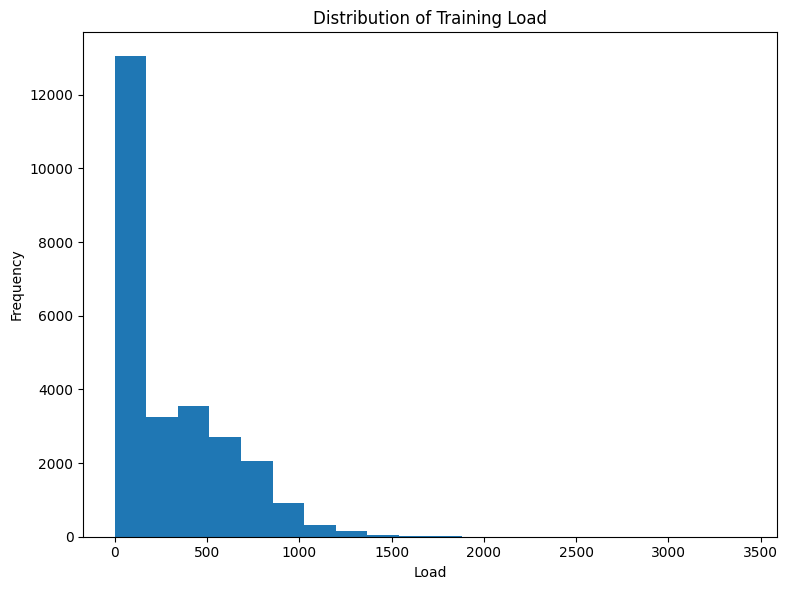

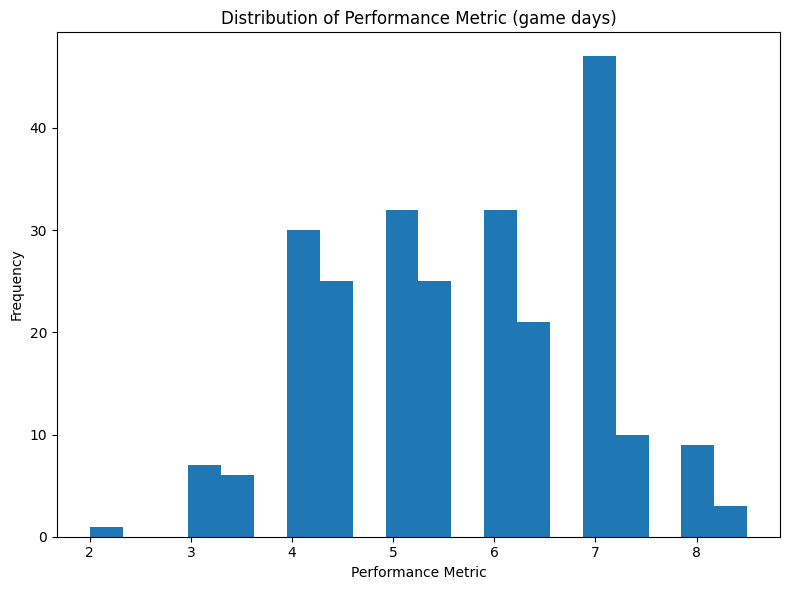

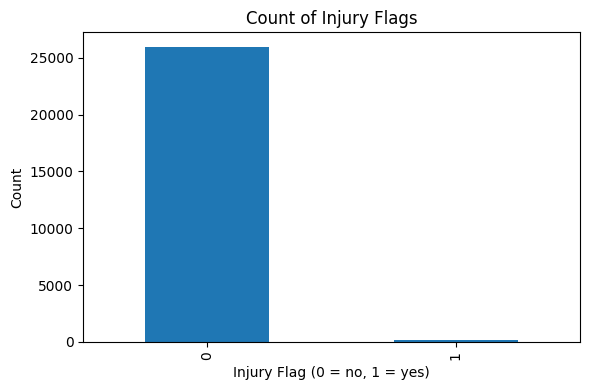

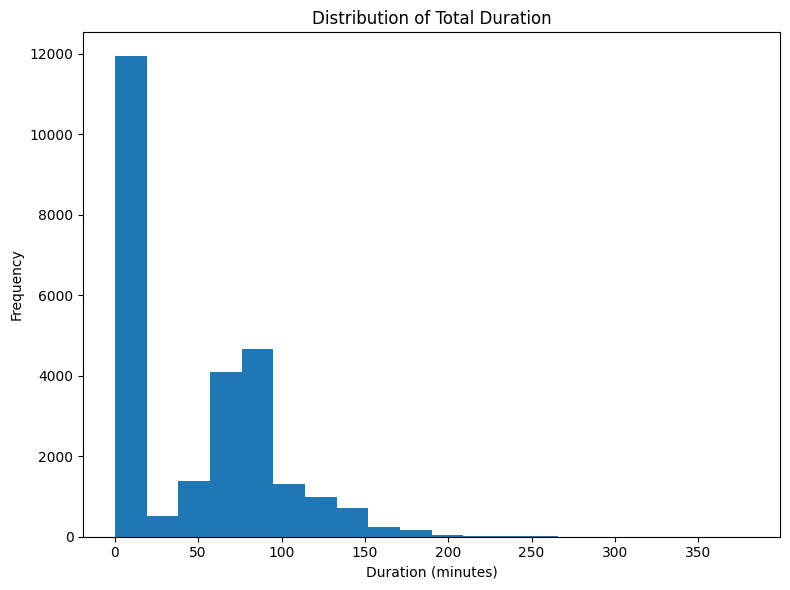

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# load cleaned data
df = pd.read_csv("data/soccer_data_cleaned.csv", parse_dates=["date"])

# subset for game days performance
game_df = df[df["action"] == "Game"]

# 1.summary statistics
stats = pd.DataFrame({
    "load":     df["load"].describe(),
    "perf":     game_df["performance_metric"].describe(),
    "duration": df["total_duration"].describe()
}).T
print("\nSummary Statistics:")
print(stats)

# 2.injury flag counts
inj_counts = df["injury_flag"].value_counts().sort_index()

# 3.plot distributions

# training Load
plt.figure(figsize=(8, 6))
plt.hist(df["load"].dropna(), bins=20)
plt.title("Distribution of Training Load")
plt.xlabel("Load")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# performance metric (game days)
plt.figure(figsize=(8, 6))
plt.hist(game_df["performance_metric"].dropna(), bins=20)
plt.title("Distribution of Performance Metric (game days)")
plt.xlabel("Performance Metric")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# injury flags
plt.figure(figsize=(6, 4))
inj_counts.plot(kind="bar")
plt.title("Count of Injury Flags")
plt.xlabel("Injury Flag (0 = no, 1 = yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# total duration
plt.figure(figsize=(8, 6))
plt.hist(df["total_duration"].dropna(), bins=20)
plt.title("Distribution of Total Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 1. Import Section

In [ ]:
import joblib
import numpy as np
import pandas as pd
import random
from collections import defaultdict, deque
import queue
import time
import heapq
import functools
import threading

global_df = defaultdict(list)
global_dp = defaultdict(list)
global_prob = defaultdict(list)

## 2. Athlete State Representation

In [ ]:
class Node:
    """
    A node in the search tree representing a state in the search space.
    
    Each node contains a state (day, fatigue, risk, performance, history),
    a reference to its parent node, the action that led to this state,
    and various cost metrics used by search algorithms.
    
    Attributes:
        state: Tuple containing (day, fatigue, risk, performance, history)
        parent: Reference to the parent Node
        action: The action (intensity, duration) that led to this state
        g: Path cost from start to this node
        f: Total evaluation function value (g + h)
        h: Heuristic value (estimated cost to goal)
        depth: Depth of this node in the search tree
    """
    def __init__(self, state, parent=None, action=None, g=0, f=0, h=0, costless=False):
        self.state = state
        self.parent = parent
        self.action = action
        if costless == False:
            self.g = g
            self.f = f
            self.h = h

        if parent is None:
            self.depth = 0
        else:
            self.depth = parent.depth + 1

    def __hash__(self):
        return hash(self.state)

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state
    
    def __gt__(self, other):
        return isinstance(other, Node) and self.f > other.f


## 3. Athlete Problem

In [ ]:
class AthletePerformanceProblem:
    """
    Search problem for athlete performance planning using learned ΔF, ΔP, ΔR models.
    State: (day, fatigue, risk, performance, history)
    Actions: Train (intensity, duration) or Rest: (0.0, 0.0)
    Transition: ML regression/classification models via simulate_step logic.
    """
# _________CONSTANTS____________
    target_fatigue = 4
    target_risk = 1
    MAX_PERFORMANCE = 10
# _________CONSTANTS____________
    def __init__(self,
                 initial_state: tuple = (0, 1.0, 0.1, 5.0),
                 target_day: int = 14,
                 target_perf: int = 8,
                 target_fatigue: float = 2.4,
                 target_risk: float = 0.2,
                 genetic: bool = False):

        # Load models
        if genetic:
            self.delta_f = joblib.load("genetic_model/delta_f_model.pkl")
            self.delta_p = joblib.load("genetic_model/delta_p_model.pkl")
            r_loaded = joblib.load("predictingModels/delta_r_classifier.pkl")
        else:
            self.delta_f = joblib.load("predictingModels/delta_f_model.pkl")
            self.delta_p = joblib.load("predictingModels/delta_p_model.pkl")
            r_loaded = joblib.load("predictingModels/delta_r_classifier.pkl")

        # Unpack classifier
        if hasattr(r_loaded, 'predict_proba') and hasattr(r_loaded, 'feature_names_in_'):
            self.delta_r = r_loaded
            self.r_feats = list(r_loaded.feature_names_in_)
        elif isinstance(r_loaded, dict):
            for v in r_loaded.values():
                if hasattr(v, 'predict_proba') and hasattr(v, 'feature_names_in_'):
                    self.delta_r = v
                if isinstance(v, (list, tuple)):
                    self.r_feats = list(v)
        else:
            raise ValueError("Unable to extract injury classifier and features")
        # Compute load-per-minute mapping
        self.LOAD_PER_MIN = calculate_load_per_minute()
        # Defaults
        self.SLEEP_DUR = 7.5
        self.SLEEP_QLT = 3.0
        self.STRESS    = 2.5
        self.f_feats = list(self.delta_f.feature_names_in_)
        self.p_feats = list(self.delta_p.feature_names_in_)
        # Initialize state history
        day, f, r, p = initial_state
        self.initial_state = (day, f, r, p, [
            {'load': 0.0,
             'fatigue': f,
             'injury_count': 0,
             'days_since_game': 0,
             'days_since_last_injury': 0}
        ])

        self.target_day = target_day
        self.target_perf = target_perf
        self.target_fatigue = target_fatigue
        self.target_risk = target_risk

    def actions(self):
        train_actions = [(i, d) for i in (0.3, 0.6, 0.9) for d in (60, 120)]
        return train_actions + [(0.0, 0.0)]  # rest

    def apply_action(self, state, action):
        # Unpack
        day, F, R, P, history = state
        intensity, duration = action
        is_rest = (intensity == 0.0 and duration == 0.0)
        # Compute load
        load = 0.0
        if not is_rest:
            load = self.LOAD_PER_MIN.get(intensity, 0.0) * duration
        # Rolling-7 calculations
        last7 = history[-7:]
        load7 = np.mean([h['load'] for h in last7] + [load])
        fat7  = np.mean([h['fatigue'] for h in last7] + [F])
        prev = history[-1]
        inj_lag1 = int(prev['injury_count'] > 0)
        # Assemble features
        feat = {
            'load': load,
            'action_intensity': intensity,
            'fatigue_post': F,
            'performance_lag_1': P,
            'sleep_duration': self.SLEEP_DUR,
            'sleep_quality':  self.SLEEP_QLT,
            'stress':         self.STRESS,
            'is_rest_day':    int(is_rest),
            'injury_flag_lag_1': inj_lag1,
            'load_rolling_7':      load7,
            'fatigue_post_rolling_7': fat7,
            'sleep_duration_rolling_7': self.SLEEP_DUR,
            'sleep_quality_rolling_7':  self.SLEEP_QLT,
            'stress_rolling_7':        self.STRESS,
            'load_lag_1':      prev['load'],
            'total_duration':  duration,
            'injury_count':    prev['injury_count'],
            'days_since_game': prev['days_since_game'] + 1,
            'days_since_last_injury': prev['days_since_last_injury'] + 1
        }
        X = pd.DataFrame([feat])
        # Predictions
        
        if is_rest:
            Rn = np.clip(R * 0.86, 0.0, 1.0)
            Fn = max(F * 0.85, 0.0)
            Pn = max(P * 0.91, 0.0)
        else:
            dF = float(self.delta_f.predict(X[self.f_feats])[0])
            dP = float(self.delta_p.predict(X[self.p_feats])[0])
            prob = self.delta_r.predict_proba(X[self.r_feats])[0, 1]
            global_df[tuple(action)].append(dF)
            global_dp[tuple(action)].append(dP)
            global_prob[tuple(action)].append(prob)
            Rn = np.clip(R + prob, 0.0, 1.0)
            Fn = np.clip(F + dF, 0.0, 5.0)
            Pn = np.clip(P + dP, 0.0, 10.0)

        # Update history
        new_rec = {
            'load': load,
            'fatigue': Fn,
            'injury_count': prev['injury_count'],
            'days_since_game': feat['days_since_game'],
            'days_since_last_injury': feat['days_since_last_injury']
        }
        new_history = history + [new_rec]
        return (day + 1, Fn, Rn, Pn, new_history)
    
    def expand_node(self, node,use_cost=False, use_heuristic=False):
        """
        Expands a node by applying all possible actions and returning the resulting nodes
        """
        children = []
        for action in self.actions():
            new_state = self.apply_action(node.state, action)
            if self.is_valid(new_state):
                cost = self.cost(node.state, action) if use_cost else 0
                heuristic = self.heuristic(new_state) if use_heuristic else 0
                child_node = Node(new_state, parent=node, action=action, cost=cost, f=cost + heuristic)
                children.append(child_node)
        return children

    def is_valid(self, state):
        day, fatigue, risk, performance, _ = state
        return (0 <= day <= self.target_day
                and 0 <= fatigue <= self.target_fatigue
                and 0 <= risk <= self.target_risk
                and 0 <= performance <= self.target_perf)

    def is_goal(self, state):
        day, fatigue, risk, performance, _ = state
        return (day == self.target_day
                and performance >= self.target_perf
                and fatigue <= self.target_fatigue
                and risk <= self.target_risk)
    
    def cost(self, state, action):
        """        
        This function balance between:
            Performance improvement (negative cost/benefit)
            increase in fatigue (cost)
            increase in injury risk (cost)
            training load (cost proportional to intensity×duration)
        
        lower cost values => better actions
        """
        day, fatigue, risk, performance, _ = state
        intensity, duration = action
        is_rest = (intensity == 0.0 and duration == 0.0)
        
        # new state after applying the action
        new_state = self.apply_action(state, action)
        _, new_fatigue, new_risk, new_perf, _ = new_state
        
        # deltas
        delta_fatigue = new_fatigue - fatigue
        delta_risk = new_risk - risk
        delta_perf = new_perf - performance
        
        if is_rest:
            # For rest days, prioritize recovery (fatigue reduction)
            recovery_efficiency = max(0, fatigue - new_fatigue)
            cost = 2 - (3 * recovery_efficiency)
            # add penality if performance drops when doing rest
            if delta_perf < -1:
                cost += 1
        else:
            # training days
            if delta_perf <= 0:
                # high cost if performance drops
                perf_factor = 5.0
            else:
                # lower cost if gain performace
                # Add small constant to avoid division by zero
                fatigue_risk_sum = max(0.01, delta_fatigue + (delta_risk * 4.0))
                perf_factor = 2.0 - min(2.0, delta_perf / fatigue_risk_sum)
            
            # extremely high penalty when risk is approaching max
            risk_proximity = new_risk / self.target_risk
            risk_penalty = 2.0 * (risk_proximity ** 2)
            
            # fatigue penalty increases when approaching max
            fatigue_proximity = new_fatigue / self.target_fatigue
            fatigue_penalty = 1.5 * (fatigue_proximity ** 2)
            
            # all cost
            cost = perf_factor + risk_penalty + fatigue_penalty
            
            # Add penalty for excessive training load
            training_load = intensity * duration
            if training_load > 80:
                cost += 0.5 * (training_load - 80) / 20
        
        return cost

    def heuristic(self, state) -> float:
        """
        Estimate how close the current state is to the goal state.
        
        This function provides a heuristic that considers:
        1. Performance deficit from target
        2. Days remaining to reach target
        3. Current fatigue and risk levels
        4. Potential for improvement over remaining days
        
        Lower heuristic values indicate more promising states.
        
        Args:
            state: Current state (day, fatigue, risk, performance, history)
            
        Returns:
            Numerical heuristic value (lower is better)
        """
        day, fatigue, risk, performance, _ = state
        
        # Calculate remaining days until target
        remaining_days = max(0, self.target_day - day)
        
        # Calculate performance deficit from target
        perf_deficit = max(0, self.target_perf - performance)
                
        # If already at the target day, evaluate based on goal conditions
        if remaining_days == 0:
            # If performance goal met and constraints satisfied, heuristic is 0
            if (performance >= self.target_perf and 
                fatigue <= self.target_fatigue and 
                risk <= self.target_risk):
                return 0.0
            
            # Otherwise, return a value based on how far we are from satisfying all conditions
            return (
                3.0 * perf_deficit + 
                2.0 * max(0, fatigue - self.target_fatigue) +
                2.0 * max(0, risk - self.target_risk)
            )
        
        # For states before the target day, estimate based on trajectory
        
        # Estimate max potential performance improvement per day, simplified and should be studied from the transition model
        max_improvement_per_day = 0.3
        
        # Estimate if we can reach the performance target in time
        potential_improvement = max_improvement_per_day * remaining_days
        if potential_improvement < perf_deficit:
            # Cannot reach target with max improvement rate, so increase heuristic
            reachability_penalty = 2.0 * (perf_deficit - potential_improvement)
        else:
            reachability_penalty = 0.0
        
        # Risk and fatigue penalties increase as we get closer to max allowed values
        risk_proximity = risk / self.target_risk if hasattr(self, 'target_risk') else risk
        fatigue_proximity = fatigue / self.target_fatigue if hasattr(self, 'target_fatigue') else fatigue / 5.0
        
        risk_penalty = 1.5 * risk_proximity**2
        fatigue_penalty = 1.0 * fatigue_proximity**2
        
        # Days factor - prioritize states that have made more progress toward goal
        days_factor = 0.8 * (1.0 - day / self.target_day)
        
        # Combined heuristic - lower values are better
        return perf_deficit + reachability_penalty + risk_penalty + fatigue_penalty + days_factor

    def random_individual(self): #Genetic
        """
        Create a random training schedule (chromosome)
        Returns a tuple (intensity, duration)
        
        """
        # default to 10
        days = getattr(self, 'target_day', 10)
        
        possible_actions = self.actions()
        
        # random schedule
        schedule = []
        for _ in range(days):
            action = random.choice(possible_actions)
            schedule.append(action) 
        return list(schedule)

    def evaluate_individual(self, indiv):
        """
        Return fitness value for an individual (list of (intensity, duration) actions).
        
        """
        state = self.initial_state
        total_cost = 0

        for action in indiv:
            # apply the action
            new_state = self.apply_action(state, action)
            # - infinity penelity when state is invalid
            if not self.is_valid(new_state):
                return float('inf')

            # add cost
            total_cost += self.cost(state, action)
            # next state
            state = new_state

        # add penality if final state is not a goal
        if not self.is_goal(state):
            total_cost += 10

        return total_cost

        

## 4. Search Algorithms

Explore and implement various search algorithms to optimize the training schedule for an athlete

### 4.1. Uninformed Search

#### Best First Search (BFS)

In [ ]:
class BFSSearch:
    """
    Implementation of Breadth-First Search algorithm for athlete training plans.
    
    This class performs a breadth-first search to find an optimal training plan
    by exploring all nodes at the current depth before moving to nodes at the next depth.
    This ensures the shortest path (in terms of number of actions) is found.
    """
    def __init__(self, problem):
        """
        Initialize the BFS search algorithm with a problem instance.
        
        Args:
            problem: An AthletePerformanceProblem instance
        """
        self.problem = problem
        self.expanded_nodes = 0
        self.max_queue_size = 0
        
        # remove them no need now
        # self.problem.target_day = 10
        # self.problem.target_perf = 6.5
        # self.problem.target_fatigue = 2.7
        # self.problem.target_risk = 0.3
        
    def search(self, max_depth=float('inf')):
        """
        Perform breadth-first search to find an optimal training plan.
        """
        start_node = Node(state=self.problem.initial_state, costless=True)
        
        # Use deque for more efficient BFS queue
        frontier = deque([start_node])
        
        # Track explored states to avoid cycles
        explored = set()
        
        while frontier:
            # Get next node to explore (FIFO for BFS)
            current_node = frontier.popleft()
            
            day, _, _, performance, _ = current_node.state
            # Check if goal state
            if self.problem.is_goal(current_node.state):
                return current_node
                
            # Skip already explored states
            rounded_state = self._round_state(current_node.state)
            if rounded_state in explored:
                continue
            
            # Mark this state as explored
            explored.add(rounded_state)
            
            # Get the valid actions from the current state
            for action in self.problem.actions():
                # Apply the action to get a new state
                # Create a state that includes history, as expected by the updated apply_action method
                current_state = current_node.state  # Full state with history
                new_state = self.problem.apply_action(current_state, action)
                
                # Skip invalid states
                if not self.problem.is_valid(new_state):
                    continue
                
                # Create a new node for this state
                child_node = Node(new_state, parent=current_node, action=action, costless=True)
                
                # Skip if exceeds maximum depth
                if child_node.depth > max_depth:
                    continue
                    
                # Add to frontier for further exploration
                frontier.append(child_node)
            
            self.expanded_nodes += 1
            
            # Track maximum queue size
            self.max_queue_size = max(self.max_queue_size, len(frontier))
            
            # Progress indicator
            if self.expanded_nodes % 500 == 0:
                print(f"Explored {self.expanded_nodes} nodes, queue size: {len(frontier)}")
            
        # If we've examined all nodes and haven't found a solution, return None
        return None
        
    def _round_state(self, state):
        """
        Round state values to reduce the state space and avoid similar states.
        """
        day, fatigue, risk, performance, _ = state
        return (
            day,
            round(fatigue, 1),  # Round fatigue to 1 decimal place
            round(risk, 1),     # Round risk to 1 decimal place
            round(performance, 1)  # Round performance to 1 decimal place
        )

    def reconstruct_path(self, node):
        """
        Reconstruct the path from the initial state to the goal state.
        """
        path = []
        while node and node.parent:
            path.append(node.action)
            node = node.parent
        return path[::-1]  # reverse to get the correct order

#### Depth First Search (DFS)

In [ ]:
class DFSSearch:
    """
    Implementation of Depth-First Search algorithm for athlete training plans.
    
    This class performs a depth-first search to find a training plan
    by exploring as far as possible along each branch before backtracking.
    DFS can find solutions quickly in some cases but does not guarantee optimality.
    """
    def __init__(self, problem):
        """
        Initialize the DFS search algorithm with a problem instance.
        
        Args:
            problem: An AthletePerformanceProblem instance
        """
        self.problem = problem
        self.expanded_nodes = 0
        self.max_stack_size = 0

        # Set target day and performance (needed for is_goal)
        # self.problem.target_day = 10
        # self.problem.target_perf = 7
        # self.problem.target_fatigue = 4
        # self.problem.target_risk = 0.3

    def search(self, max_depth=10):
        """
        Perform depth-first search to find a training plan.
        
        Args:
            max_depth: Maximum depth to explore in the search tree
        
        Returns:
            The goal node if a solution is found, None otherwise
        """
        start_node = Node(state=self.problem.initial_state, costless=True)
        # Use stack (LIFO) for DFS
        stack = deque([start_node])
        # Track explored states to avoid cycles
        explored = set()

        while stack:
            # Get next node to explore (LIFO for DFS)
            current_node = stack.pop()

            day, fatigue, risk, performance, _ = current_node.state
            # Check if goal state
            if self.problem.is_goal(current_node.state):
                print(f"Goal found! Day: {day}, Performance: {performance:.2f}, Fatigue: {fatigue:.2f}, Risk: {risk:.2f}")
                return current_node

            # Skip already explored states
            rounded_state = self._round_state(current_node.state)
            if rounded_state in explored:
                continue

            # Mark this state as explored
            explored.add(rounded_state)

            # Get the valid actions from the current state
            for action in self.problem.actions():
                # Apply the action to get a new state
                current_state = current_node.state
                new_state = self.problem.apply_action(current_state, action)

                # Skip invalid states
                if not self.problem.is_valid(new_state):
                    continue

                # Create a new node for this state
                child_node = Node(new_state, parent=current_node, action=action, costless=True)

                # Skip if exceeds maximum depth
                if child_node.depth > max_depth:
                    continue

                # Add to stack for further exploration
                stack.append(child_node)

            self.expanded_nodes += 1
            # Track maximum stack size
            self.max_stack_size = max(self.max_stack_size, len(stack))
            
            # Progress indicator
            if self.expanded_nodes % 100 == 0:
                print(f"Explored {self.expanded_nodes} nodes, stack size: {len(stack)}, " 
                      f"Current state: Day {day}, F={fatigue:.2f}, R={risk:.2f}, P={performance:.2f}, Depth={current_node.depth}")

        # If we've examined all nodes and haven't found a solution, return None
        return None

    def _round_state(self, state):
        """
        Round state values to reduce the state space and avoid similar states.
        
        Args:
            state: The state to round
            
        Returns:
            A tuple with rounded state values
        """
        day, fatigue, risk, performance, _ = state
        return (
            day,
            round(fatigue, 1),  # Round fatigue to 1 decimal place
            round(risk, 1),     # Round risk to 1 decimal place
            round(performance, 1)  # Round performance to 1 decimal place
        )

    def reconstruct_path(self, node):
        """
        Reconstruct the path from the initial state to the goal state.
        
        Args:
            node: The goal node
            
        Returns:
            A list of actions that lead from the initial state to the goal state
        """
        path = []
        while node and node.parent:
            path.append(node.action)
            node = node.parent
        return path[::-1]  # reverse to get the correct order

#### Uniform Cost Search (UCS)

In [ ]:
class UCSSearch:
    """
    Implementation of Uniform Cost Search algorithm for athlete training plans.
    
    This class performs a uniform-cost search to find an optimal training plan
    by exploring nodes with the lowest path cost (g-value) first. This guarantees
    finding the lowest-cost path to the goal state, if one exists.
    
    Attributes:
        problem: The AthletePerformanceProblem instance
        expanded_nodes: Counter of nodes expanded during search
        max_queue_size: Maximum size of the frontier queue during search
        execution_time: Time taken to execute the search
    """
    def __init__(self, problem):
        """
        Initialize the UCS search algorithm with a problem instance.
        
        Args:
            problem: An AthletePerformanceProblem instance
        """
        self.problem = problem
        self.expanded_nodes = 0
        self.max_queue_size = 0
        self.execution_time = 0
        
        # Set target day and performance
        #self.problem.target_day = 10
        #self.problem.target_perf = 7
        #self.problem.target_fatigue = 3.5
        #self.problem.target_risk = 2.5
        
    def search(self, max_depth=10):
        """
        Performs a uniform-cost search to find an optimal training plan.
        
        This method expands nodes with the lowest cumulative path cost (g-value) first,
        guaranteeing the optimal solution if one exists. It uses the problem's cost
        function to calculate the cost of each action.
        
        Args:
            max_depth: Maximum depth to explore in the search tree
            
        Returns:
            The goal node if a solution is found, None otherwise
        """
        start_time = time.time()
        
        # Create initial node from the problem's initial state
        initial_node = Node(self.problem.initial_state, g=0)
        
        # Priority queue for UCS - priority is cumulative path cost (g-value)
        frontier = queue.PriorityQueue()
        frontier.put((0, initial_node))  # Initial cost is 0
        
        # Track explored states and their costs
        explored = {}  # Maps rounded state to lowest g-value found
        
        # Best solution found so far
        best_solution = None
        best_cost = float('inf')
        
        while not frontier.empty():
            # Get node with lowest path cost
            current_cost, current_node = frontier.get()
            
            day, fatigue, risk, performance, _ = current_node.state
            
            # Check if we've reached the target day
            if self.problem.is_goal(current_node.state):
                if current_cost < best_cost:
                    best_solution = current_node
                    best_cost = current_cost
                    
                    # Since UCS guarantees the optimal path to any node,
                    # if we want the first solution at target day, we can return it
                    self.execution_time = time.time() - start_time
                    return best_solution
            
            # Don't explore beyond target day
            if day > self.problem.target_day:
                continue
                
            # Check if we've already found a better path to this state
            rounded_state = self._round_state(current_node.state)
            if rounded_state in explored and explored[rounded_state] <= current_cost:
                continue
            
            # Remember this as the best path to this state so far
            explored[rounded_state] = current_cost
            
            # Skip if exceeds maximum depth
            if current_node.depth >= max_depth:
                continue
                
            # Get valid actions for current state
            for action in self.problem.actions():
                # Apply action to get new state
                new_state = self.problem.apply_action(current_node.state, action)
                
                # Skip invalid states
                if not self.problem.is_valid(new_state):
                    continue
                
                # Calculate action cost
                action_cost = self.problem.cost(current_node.state, action)
                
                # Calculate cumulative path cost
                new_cost = current_node.g + action_cost
                
                # Create new node with updated cost
                child_node = Node(
                    state=new_state, 
                    parent=current_node, 
                    action=action, 
                    g=new_cost, 
                    f=new_cost  # In UCS, f = g (no heuristic)
                )
                
                # Add to frontier with priority based on path cost
                frontier.put((new_cost, child_node))
            
            self.expanded_nodes += 1
            
            # Track maximum queue size
            self.max_queue_size = max(self.max_queue_size, frontier.qsize())
            
            # Progress indicator
            if self.expanded_nodes % 200 == 0:
                print(f"Explored {self.expanded_nodes} nodes, queue size: {frontier.qsize()}")
        
        self.execution_time = time.time() - start_time
        return best_solution
        
    def _round_state(self, state):
        """
        Round state values to reduce the state space and avoid similar states.
        
        Args:
            state: The state to round
            
        Returns:
            A tuple with rounded values (excluding history)
        """
        day, fatigue, risk, performance, _ = state
        return (
            day,
            round(fatigue, 1),  # Round fatigue to 1 decimal place
            round(risk, 1),     # Round risk to 1 decimal place
            round(performance, 1)  # Round performance to 1 decimal place
        )
    
    def reconstruct_path(self, node):
        """
        Reconstruct the path from the initial state to the goal state.
        
        Args:
            node: The goal node
            
        Returns:
            A list of actions from start to goal in correct order
        """
        path = []
        while node and node.parent:
            path.append(node.action)
            node = node.parent
        return path[::-1]  # Reverse to get the correct order


### 4.2. Informed Search

#### Greedy Best First Search

In [ ]:
class GreedySearch:
    """
    Implementation of a greedy best-first search algorithm for athlete training plans.
    
    This class performs a greedy best-first search to find an optimal training plan
    by using a heuristic to guide the search toward promising states. The search
    expands nodes based on their heuristic values, always exploring the most
    promising node first.
    
    Attributes:
        problem: The AthletePerformanceProblem instance
        expanded_nodes: Counter of nodes expanded during search
        max_queue_size: Maximum size of the frontier queue during search
    """
    def __init__(self, problem):
        self.problem = problem
        self.expanded_nodes = 0
        self.max_queue_size = 0
        self.execution_time = 0
        
        #self.problem.target_day = 14
        #self.problem.target_perf = 9
        #self.problem.target_fatigue = 3.5
        #self.problem.target_risk = 0.5
        
    def search(self, max_depth=float('inf')):
        """
        Performs a greedy best-first search to find an optimal training plan.
        
        This method uses generates successor nodes
        and explores them based on their heuristic values (greedy best-first search).
        
        Args:
            max_depth: Maximum depth to explore in the search tree
            
        Returns:
            The goal node if a solution is found, None otherwise
        """
        start_time = time.time()
        
        # Create initial node from the problem's initial state
        initial_node = Node(self.problem.initial_state)
        
        # Priority queue for greedy best-first search
        frontier = queue.PriorityQueue()
        frontier.put((self._get_priority(initial_node), initial_node))
        
        # Track explored states to avoid cycles
        explored = set()
        
        while not frontier.empty():
            # Get next node to explore (with lowest priority/heuristic value)
            _, current_node = frontier.get()
            
            day, _, _, performance, _ = current_node.state
            
            # Check if goal state
            if day == self.problem.target_day and performance >= self.problem.target_perf:
                # Exact day match with performance target - ideal solution
                self.execution_time = time.time() - start_time
                return current_node
                            
            # Skip already explored states
            rounded_state = self._round_state(current_node.state)
            if rounded_state in explored:
                continue
            
            # Mark this state as explored
            explored.add(rounded_state)
            
            # Skip if exceeds maximum depth or target day
            if current_node.depth >= max_depth or day >= self.problem.target_day:
                continue
                
            # Get the valid actions from the current state
            for action in self.problem.actions():
                # Apply action to get a new state
                # Pass the complete state to apply_action
                new_state = self.problem.apply_action(current_node.state, action)
                
                # Skip invalid states
                if not self.problem.is_valid(new_state):
                    continue
                
                # Create a new node for this state
                child_node = Node(new_state, parent=current_node, action=action)
                
                # Add to frontier with priority based on heuristic
                frontier.put((self._get_priority(child_node), child_node))
            
            self.expanded_nodes += 1
            
            # Track maximum queue size
            self.max_queue_size = max(self.max_queue_size, frontier.qsize())
            
            # Progress indicator
            if self.expanded_nodes % 500 == 0:
                print(f"Explored {self.expanded_nodes} nodes, queue size: {frontier.qsize()}")
        
        self.execution_time = time.time() - start_time
                # If we've examined all nodes and haven't found a solution, return None
        return None
    
    def _get_priority(self, node):
        """
        Calculate priority for a node based on problem heuristic.
        Lower values have higher priority in the queue.
        """
        return self.problem.heuristic(node.state)
        
    def _round_state(self, state):
        """
        Round state values to reduce the state space and avoid similar states.
        """
        day, fatigue, risk, performance, _ = state
        return (
            day,
            round(fatigue, 1),  # Round fatigue to 1 decimal place
            round(risk, 1),     # Round risk to 1 decimal place
            round(performance, 1)  # Round performance to 1 decimal place
        )
    
    def reconstruct_path(self, node):
        """
        Reconstruct the path from the initial state to the goal state.
        
        This function traces back from the goal node to the start node
        using parent references, collecting actions along the way.
        
        Args:
            node: The goal node
            
        Returns:
            A list of actions from start to goal in correct order
        """
        path = []
        while node and node.parent:
            path.append(node.action)
            node = node.parent
        return path[::-1]  # reverse to get the correct order

#### A Star Search (A*)

In [ ]:
class AStarSearch:
    """
    A* search algorithm implementation with ML prediction caching for efficiency.
    Uses a priority queue to explore nodes in order of f-score (g + h).
    """
    def __init__(self, problem):
        self.problem = problem
        self.heuristic_cache = {}  # Cache for heuristic values
        self.expanded_nodes = 0
        self.max_queue_size = 0
        self.execution_time = 0
        
        # ML model prediction cache
        self.prediction_cache = {}
        self.prediction_lock = threading.Lock()  # Lock for thread safety
        self.prediction_hits = 0
        self.prediction_misses = 0
        
        # Set default target parameters if not already set
        if not hasattr(self.problem, 'target_day'):
            self.problem.target_day = 14
        if not hasattr(self.problem, 'target_perf'):
            self.problem.target_perf = 7.0
        if not hasattr(self.problem, 'target_fatigue'):
            self.problem.target_fatigue = 3.5
        if not hasattr(self.problem, 'target_risk'):
            self.problem.target_risk = 0.5
        
        # Apply monkey patch to problem's apply_action for caching
        self._patch_apply_action()
    
    def _patch_apply_action(self):
        """Monkey patch the problem's apply_action method to add caching"""
        original_apply_action = self.problem.apply_action
        
        @functools.wraps(original_apply_action)
        def cached_apply_action(state, action):
            # Create a cache key from relevant state components and action
            day, fatigue, risk, performance, history = state
            
            # Use only last state for caching to reduce key size
            if history and len(history) > 0:
                last_history_item = history[-1]
            else:
                last_history_item = {}
                
            # Create a hashable cache key
            cache_key = (day, round(fatigue, 2), round(risk, 2), round(performance, 2), 
                        tuple(sorted(last_history_item.items())) if last_history_item else None,
                        action)
            
            # Check if we already computed this state transition
            with self.prediction_lock:
                if cache_key in self.prediction_cache:
                    self.prediction_hits += 1
                    return self.prediction_cache[cache_key]
                
                # If not in cache, compute it
                self.prediction_misses += 1
                result = original_apply_action(state, action)
                
                # Cache the result if cache size is reasonable
                if len(self.prediction_cache) < 100000:  # Set a reasonable cache size limit
                    self.prediction_cache[cache_key] = result
                    
                return result
                
        # Replace the original method with our cached version
        self.problem.apply_action = cached_apply_action
    
    def get_state_key(self, state):
        """Creates a hashable key from a state by rounding numeric values."""
        day, fatigue, risk, performance, _ = state
        return (day, round(fatigue, 1), round(risk, 2), round(performance, 1))
    
    def get_heuristic(self, state):
        """Gets the heuristic value for a state, using cache when possible."""
        state_key = self.get_state_key(state)
        if state_key in self.heuristic_cache:
            return self.heuristic_cache[state_key]
        
        h_value = self.problem.heuristic(state)
        self.heuristic_cache[state_key] = h_value
        return h_value
    
    def search(self, max_iterations=10000, time_limit=240, exact_days=True):
        """
        Performs A* search to find an optimal training plan.
        
        Args:
            max_iterations: Maximum number of iterations to prevent infinite loops
            time_limit: Maximum time in seconds to run search
            exact_days: Whether to require exact day match for goal state
            
        Returns:
            The goal node if a solution is found, None otherwise
        """
        start_time = time.time()
        
        # Initialize the start node
        start_node = Node(self.problem.initial_state)
        start_node.g = 0  # Cost from start to start is 0
        start_node.h = self.get_heuristic(start_node.state)
        start_node.f = start_node.g + start_node.h
        
        # Initialize open and closed sets
        open_set = []  # Priority queue
        heapq.heappush(open_set, (start_node.f, id(start_node), start_node))  # Using object ID as tiebreaker
        
        # Use a dictionary for O(1) lookups in the open set
        open_dict = {self.get_state_key(start_node.state): start_node}
        
        # Closed set to track visited states
        closed_set = set()
        
        iterations = 0
        while open_set and iterations < max_iterations:
            # Check time limit
            if time.time() - start_time > time_limit:
                print(f"Search time limit reached ({time_limit}s)")
                break
                
            iterations += 1
            
            # Track max queue size for metrics
            self.max_queue_size = max(self.max_queue_size, len(open_set))
            
            # Get node with lowest f-score
            _, _, current_node = heapq.heappop(open_set)
            current_key = self.get_state_key(current_node.state)
            
            # Remove from open dictionary
            if current_key in open_dict:
                del open_dict[current_key]
            
            # Check if we reached a goal state
            day, fatigue, risk, performance, _ = current_node.state
            
            # Modified goal state check to enforce exact day match if requested
            day_condition = (day == self.problem.target_day) if exact_days else (day >= self.problem.target_day)
            
            if (day_condition and 
                performance >= self.problem.target_perf and
                fatigue <= self.problem.target_fatigue and
                risk <= self.problem.target_risk):
                self.execution_time = time.time() - start_time
                print(f"ML prediction cache: {self.prediction_hits} hits, {self.prediction_misses} misses")
                return current_node
            
            # Skip if we've already processed this state
            if current_key in closed_set:
                continue
            
            # Add to closed set
            closed_set.add(current_key)
            self.expanded_nodes += 1
            
            # Print progress periodically
            if self.expanded_nodes % 100 == 0:
                elapsed = time.time() - start_time
                print(f"Expanded {self.expanded_nodes} nodes, queue size: {len(open_set)}, time: {elapsed:.1f}s")
            
            # Get all possible actions for the current state
            for action in self.problem.actions():
                # Apply the action to get a new state
                new_state = self.problem.apply_action(current_node.state, action)
                
                # Skip invalid states
                if not self.problem.is_valid(new_state):
                    continue
                
                # Create a new node for this state
                new_node = Node(new_state, parent=current_node, action=action)
                
                # Calculate g-score (cost from start)
                new_g = current_node.g + self.problem.cost(current_node.state, action)
                
                # Get the state key for checking in open/closed sets
                new_key = self.get_state_key(new_state)
                
                # Skip if we've already processed this state
                if new_key in closed_set:
                    continue
                
                # If this state is already in the open set, check if our new path is better
                if new_key in open_dict:
                    existing_node = open_dict[new_key]
                    if new_g >= existing_node.g:
                        # Our path is not better, skip
                        continue
                
                # This is a better path to the state, update or add to open set
                new_node.g = new_g
                new_node.h = self.get_heuristic(new_state)
                new_node.f = new_node.g + new_node.h
                
                # Add to open set
                heapq.heappush(open_set, (new_node.f, id(new_node), new_node))
                open_dict[new_key] = new_node
        
        self.execution_time = time.time() - start_time
        print(f"ML prediction cache: {self.prediction_hits} hits, {self.prediction_misses} misses")
        
        # If we've examined all nodes and haven't found a solution, return None
        return None
    
    def reconstruct_path(self, goal_node, truncate_to_target_day=True):
        """
        Reconstructs the path from start to goal node.
        
        Args:
            goal_node: The final node to backtrack from
            truncate_to_target_day: Whether to truncate the path to exactly target_day days
            
        Returns:
            A list of actions (intensity, duration) from start to goal
        """
        actions = []
        current = goal_node
        
        # Collect all actions from goal to start
        while current.parent:
            actions.append(current.action)
            current = current.parent
        
        # Reverse to get path from start to goal
        actions = actions[::-1]
        
        # If truncating and we have more actions than target_day, trim the excess
        if truncate_to_target_day and len(actions) > self.problem.target_day:
            actions = actions[:self.problem.target_day]
            print(f"Note: Path truncated from {len(actions)} to {self.problem.target_day} days")
            
        return actions

### 4.3. Local Search

#### Genetic Algorithm

In [ ]:
pass

## 5. Constraints Satisfacton (CSP)

In [ ]:
class AthleteTrainingCSP:
    """
    Implementation of a Constraint Satisfaction Problem approach for athlete training planning
    using backtracking search.
    
    The CSP approach models the athlete training planning problem with:
    - Variables: Training activities for each day
    - Domains: Possible training intensities and durations for each day
    - Constraints: Fatigue limits and injury risk thresholds
    - Objective: Maximize performance
    """
    
    def __init__(self, 
        initial_state=(0, 0.0, 0.0, 1.0),
        target_day=30,
        max_fatigue=2.7,
        max_risk=0.5):
        
        # an object of the problem definition
        self.athlete_problem = AthletePerformanceProblem(initial_state=initial_state)
        
        # Thresholds
        self.target_day = target_day
        self.max_fatigue = max_fatigue
        self.max_risk = max_risk
        
        # Initialize state with history
        day, f, r, p = initial_state
        self.initial_state = (day, f, r, p, [
            {'load': 0.0,
            'fatigue': f,
            'injury_count': 0,
            'days_since_game': 0,
            'days_since_last_injury': 0}
        ])
        
        self.intensities = [0.0, 0.3, 0.6, 0.9]
        self.durations = [0, 60, 90, 120]
        
        # the domains: possible intensities and durations
        self.domains = set()
        
        # all possible pairs of intensity and duration
        for intensity in self.intensities:
            for duration in self.durations:
                if (intensity==0.0 and duration==0) or (intensity> 0.0 and duration>0):
                    self.domains.add((intensity, duration))

        self.transition_cache = {} # Cache for performance optimization
        
        # backtracking stats
        self.backtrack_stats = {
            'iterations': 0,
            'max_depth': 0,
            'pruning_count': 0
        }

    def get_domains(self):
        return self.domains
    
    def apply_action(self, state, action):
        
        # caching to avoid recalculating
        cache_key = (str(state), str(action))
        if cache_key in self.transition_cache:
            return self.transition_cache[cache_key]
                
        day, fatigue, risk, performance, history = state
        
        basic_state = (day, fatigue, risk, performance, history) # tuple of only four elements !!!
        
        # apply the transition
        new_state = self.athlete_problem.apply_action(basic_state, action)
        
        self.transition_cache[cache_key] = new_state    # cache the answer
        return new_state
    
    def check_constraints(self, state):
        _, fatigue, risk, _, _ = state
        return fatigue <= self.max_fatigue and risk <= self.max_risk

    def evaluate_solution(self, solution):

        current_state = self.initial_state
        states = [current_state]
        
        # Apply each action in the solution
        for action in solution:
            current_state = self.apply_action(current_state, action)
            states.append(current_state)
        
        # Get final state
        final_day, final_fatigue, final_risk, final_performance, _ = states[-1]
        
        # Calculate metrics
        highest_fatigue = max(state[1] for state in states)
        highest_risk = max(state[2] for state in states)
        constraints_violated = any(state[1] > self.max_fatigue or state[2] > self.max_risk for state in states)
        
        # Calculate training metrics
        rest_days = sum(1 for action in solution if action[0] == 0.0 and action[1] == 0)
        high_intensity_days = sum(1 for action in solution if action[0] >= 0.7)
        total_workload = sum(self.athlete_problem.LOAD_PER_MIN.get(action[0], 0) * action[1] for action in solution)
        
        return {
            'final_performance': final_performance,
            'highest_fatigue': highest_fatigue,
            'final_fatigue': final_fatigue,
            'final_risk': final_risk,
            'highest_risk': highest_risk,
            'constraints_violated': constraints_violated,
            'days_trained': final_day,
            'rest_days': rest_days,
            'high_intensity_days': high_intensity_days,
            'total_workload': total_workload
        }

    def backtracking_search(self, time_limit=120):
        # reset our tracking stats for this search run
        self.backtrack_stats = {
            'iterations': 0,
            'max_depth': 0,
            'pruning_count': 0
        }
        
        solution_found = False 
        solution = []   
        
        # nested backtracking function that does the recursive search
        def _backtrack(assignment, current_state, depth=0):
            nonlocal solution_found, solution
            if solution_found:
                return True
            
            # track how many iterations we've done and how deep we've gone
            self.backtrack_stats['iterations'] += 1
            self.backtrack_stats['max_depth'] = max(self.backtrack_stats['max_depth'], depth)
            
            # make sure we haven't exceeded our time limit
            if time.time() - start_time > time_limit:
                return False
            
            day, fatigue, risk, performance, _ = current_state

            # check if we've reached our goal - the target day
            if day >= self.target_day:
                # done, we assgined each day with of intensity and duration
                solution_found = True
                solution = assignment.copy()
                return True
            
            # get possible actions for this day, ordered from most promising to least
            actions = self._get_ordered_domain_values(current_state)
            
            for action in actions:
                # try this action and see where it leads
                new_state = self.apply_action(current_state, action)
                
                # make sure this action doesn't break any constraints
                if self.check_constraints(new_state):
                    assignment.append(action)
                    
                    # recursively continue down this path
                    if _backtrack(assignment, new_state, depth + 1):
                        return True  
                    
                    # remove the last added assignment and redo the backtracking
                    assignment.pop()
                    
                    # if somehow a solution was found after backtracking, we can stop
                    if solution_found:
                        return True
            
            return False  # no solution found in this branch
        
        start_time = time.time()        
        _backtrack([], self.initial_state)
        end_time = time.time()
        
        if solution_found:
            print(f"First valid solution found in {end_time - start_time:.2f} seconds")
            # calculate how good this solution is
            evaluation = self.evaluate_solution(solution)
            print(f"Performance: {evaluation['final_performance']:.2f}")
        else:
            print(f"No solution found within time limit of {time_limit} seconds")
        
        return solution
    
    
    #### FUNCTION DEFINITION: ORDERING DOMAIN VALUES
    # This function is the heart of the CSP optimizer's decision-making process.
    # It determines which training actions should be tried first during backtracking search.
    def _get_ordered_domain_values(self, state):
        """
        Advanced priority ordering of domain values (actions) with a sophisticated formula 
        that heavily prioritizes performance maximization above all else.
        """
        
        # Unpacking the state variables for easier access
        day, fatigue, risk, performance, history = state
        actions = self.get_domains()
        action_values = {}
        
        
        #### CONFIGURATION: OPTIMIZATION WEIGHTS
        PERFORMANCE_WEIGHT = 1000      # 1000 because its our primary objective
        
        # Headroom refers to the remaining capacity between the current fatigue/risk levels and their maximum allowable limits.
        # It indicates how much more stress the athlete can safely handle before reaching their physiological limits.
        # Higher headroom means more flexibility for intense training in the future.
        FATIGUE_HEADROOM_WEIGHT = 15   
        RISK_HEADROOM_WEIGHT = 20      
        
        ## Training pattern weights ensure physiologically sound training progression
        RECOVERY_BONUS = 30            # Value the recovery when fatigue is high
        LONG_TERM_POTENTIAL = 80      # Value actions with potential future payoff
        
        EFFICIENCY= 200
        
        #### PREPARATION: CALCULATE CURRENT STATE METRICS
        ## headroom: how much more fatigue/risk the athlete can handle
        # 0 means he can handle nothing
        fatigue_headroom = max(0, self.max_fatigue - fatigue)
        risk_headroom = max(0, self.max_risk - risk)
        
        # Count consecutive training days (days without rest)
        days_since_rest = sum(1 for h in reversed(history) if h.get('load', 0) > 0.1)
        
        # fatigue and risk status
        # >80% of maximum?  
        high_fatigue = fatigue > (self.max_fatigue * 0.8)
        high_risk = risk > (self.max_risk * 0.8)
        remaining_days_factor= ((day+1)/self.target_day)
        #### EVALUATION: evaluate EACH POSSIBLE ACTION
        for action in actions:
            intensity, duration = action
            
            future_state = self.apply_action(state, action)
            _, future_fatigue, future_risk, future_performance, _ = future_state
            
            ## violate constraints are given negative infinity (so it goes to the end when the domain is sorted)
            if future_fatigue > self.max_fatigue or future_risk > self.max_risk:
                action_values[action] = -float('inf') 
                self.backtrack_stats['pruning_count'] += 1 
                continue  
            
            perf_improvement = future_performance - performance
            
            ## Training efficiency metrics
            # Calculate standardized training load (hours equivalent)
            training_load = intensity * (duration / 60) 

            # Calculate performance gain per unit of training load (with safeguard against division by zero)
            efficiency = perf_improvement / max(0.5, training_load) if training_load > 0 else 0
            
            # Calculate future headroom values to see how action affects future training capacity
            future_fatigue_headroom = max(0, self.max_fatigue - future_fatigue)
            future_risk_headroom = max(0, self.max_risk - future_risk)
                        
            recovery_value = 0
            if intensity == 0 and duration == 0:  # Rest day
                if high_fatigue:
                    # we give bonuses for the rest if the athlete have high fatigue 
                    recovery_value = fatigue * RECOVERY_BONUS
                
                if days_since_rest > 3:  
                    # bonus if the athlete hasn't rested in >3 days
                    recovery_value += days_since_rest * 5
            
            
            # this one has the most important impact on finding an optimal schudule            
            # high intensity training -> future capacity
            # we then multiply by the factor of the remaining days because we want the performance to be maximized at the target day not before
            # this factor may be negative because remaining_days_factor
            long_term_value = (intensity)*(duration / 60)* (1-remaining_days_factor) 


            ## Performance valuation with exponential weighting
            # Square positive performance improvements to emphasize their value
            # Linear weighting for negative performance (avoids excessively punishing small negatives)
            performance_value = perf_improvement ** 2 * PERFORMANCE_WEIGHT if perf_improvement > 0 else perf_improvement * PERFORMANCE_WEIGHT
            
            #print(f"day:{day}")
            #print(f"long_term_value: {long_term_value}")
            #print(f"prformance: {performance_value}")
            #### FINAL SCORING: COMBINE ALL COMPONENTS
            action_values[action] = (
                performance_value*remaining_days_factor +
                efficiency * EFFICIENCY + 
                (future_fatigue_headroom - fatigue_headroom) * FATIGUE_HEADROOM_WEIGHT + 
                (future_risk_headroom - risk_headroom) * RISK_HEADROOM_WEIGHT +
                recovery_value + 
                long_term_value * LONG_TERM_POTENTIAL 
            )
        # Sort actions in descending order (best first) based on the scoring system we set
        return sorted(actions, key=lambda a: action_values.get(a, 0), reverse=True)

## 6. Test Implementation

In [ ]:
def display_training_plan(problem, initial_state, path, additional_info=None):
    """
    Display the training plan as a table.
    
    Args:
        problem: The problem instance
        initial_state: The initial state of the problem
        path: List of actions forming the solution path
        additional_info: Dictionary with additional information to display
    """
    print("\nTraining Plan:")
    print("Day | Intensity | Duration | Fatigue | Risk | Performance")
    print("----|-----------|----------|---------|------|------------")
    
    # Display initial state
    state = initial_state
    day = state[0]
    print(f"{day:3d} | {'-':9} | {'-':8} |  {state[1]:.2f}   | {state[2]:.2f} | {state[3]:.2f}")
    
    # Display each day in the training plan
    current_state = state
    for action in path:
        # Apply action to get the new state
        current_state = problem.apply_action(current_state, action)
        day, fatigue, risk, performance, _ = current_state
        intensity, duration = action
        
        # Categorize rest days based on intensity
        if intensity == 0.0 and duration == 0.0:
            if fatigue > 2.0:
                rest_type = "Passive Rest"
            else:
                rest_type = "Active Rest"
            print(f"{day:3d} | {rest_type:9} | {'-':8} |  {fatigue:.2f}   | {risk:.2f} | {performance:.2f}")
        else:
            print(f"{day:3d} | {intensity:9.1f} | {duration:8.1f} |  {fatigue:.2f}   | {risk:.2f} | {performance:.2f}")
    
    # Display final state summary
    final_day, final_fatigue, final_risk, final_perf, _ = current_state
    print("\nFinal State:")
    print(f"Day: {final_day}")
    print(f"Fatigue: {final_fatigue:.2f}/5.00")
    print(f"Risk: {final_risk:.2f}/1.00")
    print(f"Performance: {final_perf:.2f}/10.00")
    
    # Display additional information if provided
    if additional_info:
        print("\nSearch Statistics:")
        for key, value in additional_info.items():
            if isinstance(value, float):
                print(f"{key}: {value:.2f}")
            else:
                print(f"{key}: {value}")
    
    # Report whether goal was achieved
    if problem.is_goal(current_state):
        print("\nGoal achieved!")
    else:
        print("\nGoal not achieved.")

def test_bfs_search(initial_state, target_day, target_perf, target_fatigue, target_risk):
    """
    Test the BFS algorithm with given parameters.
    """
    print("Testing BFS Algorithm")
    print("-----------------------------------------")
    
    # Create the athlete performance problem with parameters
    problem = AthletePerformanceProblem(initial_state=initial_state)
    problem.target_day = target_day
    problem.target_perf = target_perf
    problem.target_fatigue = target_fatigue
    problem.target_risk = target_risk
    
    # Create the BFS algorithm
    searcher = BFSSearch(problem)

    # Run the search algorithm
    print("Starting search...")
    start_time = time.time()
    goal_node = searcher.search()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Search completed. Nodes explored: {searcher.expanded_nodes}")
    
    # Report the results
    if goal_node is None:
        print("No solution found.")
    else:
        # Reconstruct the path from initial state to goal
        path = searcher.reconstruct_path(goal_node)
        
        # Additional information for display
        additional_info = {
            "Execution Time": execution_time,
            "Expanded Nodes": searcher.expanded_nodes,
            "Max Queue Size": getattr(searcher, 'max_queue_size', 'N/A')
        }
        
        # Display the training plan
        display_training_plan(problem, problem.initial_state, path, additional_info)

def test_dfs_search(initial_state, target_day, target_perf, target_fatigue, target_risk):
    """
    Test the DFS algorithm with given parameters.
    """
    print("Testing DFS Algorithm")
    print("-----------------------------------------")

    # Create the athlete performance problem with parameters
    problem = AthletePerformanceProblem(initial_state=initial_state)
    problem.target_day = target_day
    problem.target_perf = target_perf
    problem.target_fatigue = target_fatigue
    problem.target_risk = target_risk

    # Create the DFS searcher
    searcher = DFSSearch(problem)

    # Run the search algorithm
    print("Starting search...")
    start_time = time.time()
    goal_node = searcher.search()
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Search completed. Nodes explored: {searcher.expanded_nodes}")

    if goal_node is None:
        print("No solution found.")
    else:
        # Reconstruct the path from initial state to goal
        path = searcher.reconstruct_path(goal_node)
        
        # Additional information for display
        additional_info = {
            "Execution Time": execution_time,
            "Expanded Nodes": searcher.expanded_nodes,
            "Max Queue Size": getattr(searcher, 'max_queue_size', 'N/A')
        }
        
        # Display the training plan
        display_training_plan(problem, problem.initial_state, path, additional_info)

def test_ucs_search(initial_state, target_day, target_perf, target_fatigue, target_risk):
    """
    Test the UCS algorithm with given parameters.
    """
    print("Testing Uniform Cost Search Algorithm")
    print("-----------------------------------------")
    
    # Create the athlete performance problem with parameters
    problem = AthletePerformanceProblem(initial_state=initial_state)
    problem.target_day = target_day
    problem.target_perf = target_perf
    problem.target_fatigue = target_fatigue
    problem.target_risk = target_risk
    
    # Create the UCS searcher
    searcher = UCSSearch(problem)
    
    # Run the search algorithm
    print("Starting search...")
    goal_node = searcher.search()
    print(f"Search completed. Nodes explored: {searcher.expanded_nodes}")
    
    if goal_node is None:
        print("No solution found.")
    else:
        path = searcher.reconstruct_path(goal_node)
        
        # Additional information for display
        additional_info = {
            "Total Path Cost": goal_node.g,
            "Execution Time": searcher.execution_time,
            "Expanded Nodes": searcher.expanded_nodes,
            "Max Queue Size": searcher.max_queue_size
        }
        
        # Display the training plan
        display_training_plan(problem, problem.initial_state, path, additional_info)

def test_greedy_search(initial_state, target_day, target_perf, target_fatigue, target_risk):
    """
    Test the greedy search algorithm with given parameters.
    """
    print("Testing Greedy Search Algorithm")
    print("-----------------------------------------")
    
    # Create the athlete performance problem with parameters
    problem = AthletePerformanceProblem(initial_state=initial_state)
    problem.target_day = target_day
    problem.target_perf = target_perf
    problem.target_fatigue = target_fatigue
    problem.target_risk = target_risk
    
    # Create the greedy searcher
    searcher = GreedySearch(problem)
    
    # Run the search algorithm
    print("Starting search...")
    goal_node = searcher.search()
    print(f"Search completed. Nodes explored: {searcher.expanded_nodes}")
    
    if goal_node is None:
        print("No solution found.")
    else:
        path = searcher.reconstruct_path(goal_node)
        
        # Additional information for display
        additional_info = {
            "Execution Time": searcher.execution_time,
            "Expanded Nodes": searcher.expanded_nodes,
            "Max Queue Size": searcher.max_queue_size
        }
        
        # Display the training plan
        display_training_plan(problem, problem.initial_state, path, additional_info)

def test_astar_search(initial_state, target_day, target_perf, target_fatigue, target_risk, max_iterations, time_limit, exact_days):
    """
    Test the A* search algorithm with given parameters.
    """
    print(f"Testing A* Search Algorithm")
    print("-----------------------------------------")
    
    # Create the problem with specified parameters
    problem = AthletePerformanceProblem(initial_state=initial_state)
    problem.target_day = target_day
    problem.target_perf = target_perf
    problem.target_fatigue = target_fatigue
    problem.target_risk = target_risk
    
    # Create and run the A* search
    astar = AStarSearch(problem)
    goal_node = astar.search(max_iterations=max_iterations, time_limit=time_limit, exact_days=exact_days)
    
    if goal_node:
        # Get the path of actions with truncation if exact_days is True
        actions = astar.reconstruct_path(goal_node, truncate_to_target_day=exact_days)
        
        # Additional information for display
        additional_info = {
            "Execution Time": astar.execution_time,
            "Expanded Nodes": astar.expanded_nodes,
            "Max Queue Size": astar.max_queue_size,
            "ML Prediction Cache Hits": astar.prediction_hits if hasattr(astar, 'prediction_hits') else 'N/A',
            "ML Prediction Cache Misses": astar.prediction_misses if hasattr(astar, 'prediction_misses') else 'N/A'
        }
        
        # Display the training plan
        display_training_plan(problem, problem.initial_state, actions, additional_info)
    else:
        print("\nNo solution found within iteration/time limit.")
        print(f"Nodes expanded: {astar.expanded_nodes}")
        print(f"Max queue size: {astar.max_queue_size}")
        print(f"Execution time: {astar.execution_time:.2f} seconds")
        if hasattr(astar, 'prediction_hits'):
            print(f"ML prediction cache: {astar.prediction_hits} hits, {astar.prediction_misses} misses")

def test_backtracking_csp_max_performance(initial_state, target_day, target_fatigue, target_risk, time_limit):
    """
    Test the CSP approach with optimized backtracking for maximum performance.
    """
    print("Testing CSP Athlete Training Planner for Maximum Performance")
    print("---------------------------------------------------------")
    
    # CSP problem with given parameters
    problem = AthleteTrainingCSP(
        initial_state=initial_state,
        target_day=target_day,
        target_fatigue=target_fatigue,
        target_risk=target_risk
    )
    
    print("Finding solution to maximize performance...")
    start_time = time.time()
    solution = problem.backtracking_search(time_limit=time_limit) 
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"Search completed in {execution_time:.2f} seconds")
    print(f"Backtracking iterations: {problem.backtrack_stats['iterations']}")
    print(f"Maximum depth reached: {problem.backtrack_stats['max_depth']}")
    print(f"Number of branches pruned: {problem.backtrack_stats['pruning_count']}")
    
    if solution is None:
        print("No solution found.")
        return
    
    # Additional information for display
    additional_info = {
        "Execution Time": execution_time,
        "Backtracking Iterations": problem.backtrack_stats['iterations'],
        "Maximum Depth": problem.backtrack_stats['max_depth'],
        "Branches Pruned": problem.backtrack_stats['pruning_count']
    }
    
    # Display the training plan
    display_training_plan(problem, problem.initial_state, solution, additional_info)
    
    # Evaluate solution
    evaluation = problem.evaluate_solution(solution)
    print("\nSolution Evaluation:")
    print(f"Final Performance: {evaluation['final_performance']:.2f}")
    print(f"Constraints Violated: {'Yes' if evaluation['constraints_violated'] else 'No'}")
    print(f"Highest Fatigue: {evaluation['highest_fatigue']:.2f}/{problem.target_fatigue:.2f}")
    print(f"Highest Risk: {evaluation['highest_risk']:.2f}/{problem.target_risk:.2f}")
    print(f"Rest Days: {evaluation['rest_days']}/{evaluation['days_trained']}")
    print(f"High Intensity Days: {evaluation['high_intensity_days']}")
    print(f"Total Workload: {evaluation['total_workload']:.2f}")

## 7. Main Function

In [ ]:
# specify the parameters
INIT_PERFORMANCE = 6.5
INIT_FATIGUE = 1.5
INIT_RISK = 0.15

TARGET_PERFORMANCE = 7
TRAINING_DAYS = 10
TARGET_FATIGUE = 2.65
TARGET_RISK = 0.2

# A start specific
TIME_LIMIT= 600
MAX_ITER= 50000
EXACT_DAYS= True


initial_state = (0, INIT_FATIGUE, INIT_RISK, INIT_PERFORMANCE)

def test_all():

    # test_greedy_search(initial_state=initial_state, target_day=TRAINING_DAYS, target_perf=TARGET_PERFORMANCE, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK)

    # test_backtracking_csp_max_performance(initial_state=initial_state, target_day=TRAINING_DAYS, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK, time_limit=TIME_LIMIT)

    # test_astar_search(initial_state=initial_state, target_day=TRAINING_DAYS, target_perf=TARGET_PERFORMANCE, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK, max_iterations=MAX_ITER, time_limit=TIME_LIMIT, exact_days=EXACT_DAYS)
    
    test_bfs_search(initial_state=initial_state, target_day=TRAINING_DAYS, target_perf=TARGET_PERFORMANCE, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK)

    # test_dfs_search(initial_state=initial_state, target_day=TRAINING_DAYS, target_perf=TARGET_PERFORMANCE, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK)

    # test_ucs_search(initial_state=initial_state, target_day=TRAINING_DAYS, target_perf=TARGET_PERFORMANCE, target_fatigue=TARGET_FATIGUE, target_risk=TARGET_RISK)


test_all()

